import library

In [1]:
!pip install Sastrawi
!pip install torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_scheduler
from torch.utils.data import DataLoader, Dataset
import torch
from tqdm.auto import tqdm
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
import pandas as pd
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud


data = pd.read_csv('sentimen_analisis.csv')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 1.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

preprocessing data

In [2]:
data_new = data.copy()

In [3]:
data_new.head()

,author,comment,published_at,label
0,@user-cu9kh2pm6r,"Negara ini sudah UGD korupsi,salah Negara huku...",2024-05-08T11:47:04Z,1
1,@HafizMutira,Hukum mati aja kek Korut. Indonesia wajar gak ...,2024-04-12T08:39:18Z,1
2,@MunirMunit,Saya setuju hukum mati koruptor,2024-04-10T12:08:29Z,1
3,@irfanmansyur1761,Korupsi harus hukum mati ..baru makmur indonesia,2024-04-01T09:58:37Z,1
4,@YuhenDri-gw5rz,yang hadir tubuh tubuh besar,2024-03-30T10:34:30Z,0


In [4]:
data_new

,author,comment,published_at,label
0,@user-cu9kh2pm6r,"Negara ini sudah UGD korupsi,salah Negara huku...",2024-05-08T11:47:04Z,1
1,@HafizMutira,Hukum mati aja kek Korut. Indonesia wajar gak ...,2024-04-12T08:39:18Z,1
2,@MunirMunit,Saya setuju hukum mati koruptor,2024-04-10T12:08:29Z,1
3,@irfanmansyur1761,Korupsi harus hukum mati ..baru makmur indonesia,2024-04-01T09:58:37Z,1
4,@YuhenDri-gw5rz,yang hadir tubuh tubuh besar,2024-03-30T10:34:30Z,0
...,...,...,...,...
995,@user-gg1qn6so4q,Wk wk wk dom aceh trisakti bbm naik. Lapar lag...,2023-05-24T10:23:05Z,0
996,@user-gg1qn6so4q,Tol aceh 100t dari arab kemana?,2023-05-24T10:20:12Z,0
997,@user-gg1qn6so4q,Indosat kemana,2023-05-24T10:16:16Z,0
998,@pandikacell4364,Hukum .potong tangan kanan saja baru pengajaran,2023-05-24T10:12:30Z,1


In [5]:
data_new.to_csv('sentimen_analisis.csv', index=False)

In [6]:
stop_words = StopWordRemoverFactory().get_stop_words()
new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

data_new['comment'] = data_new['comment'].apply(lambda x: stopword(x))
data_new.head()

,author,comment,published_at,label
0,@user-cu9kh2pm6r,"Negara sudah UGD korupsi,salah Negara hukum ko...",2024-05-08T11:47:04Z,1
1,@HafizMutira,Hukum mati aja kek Korut. Indonesia wajar gak ...,2024-04-12T08:39:18Z,1
2,@MunirMunit,Saya setuju hukum mati koruptor,2024-04-10T12:08:29Z,1
3,@irfanmansyur1761,Korupsi hukum mati ..baru makmur indonesia,2024-04-01T09:58:37Z,1
4,@YuhenDri-gw5rz,hadir tubuh tubuh besar,2024-03-30T10:34:30Z,0


In [7]:
tokenized = data_new['comment'].apply(lambda x:x.split())
tokenized

0      [Negara, sudah, UGD, korupsi,salah, Negara, hu...
1      [Hukum, mati, aja, kek, Korut., Indonesia, waj...
2                  [Saya, setuju, hukum, mati, koruptor]
3      [Korupsi, hukum, mati, ..baru, makmur, indonesia]
4                           [hadir, tubuh, tubuh, besar]
                             ...                        
995    [Wk, wk, wk, dom, aceh, trisakti, bbm, naik., ...
996                     [Tol, aceh, 100t, arab, kemana?]
997                                            [Indosat]
998    [Hukum, .potong, tangan, kanan, baru, pengajaran]
999    [Selama, hukuman, mati, perampasan, seluruh, a...
Name: comment, Length: 1000, dtype: object

In [8]:
def stemming(comment):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in comment:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  print(d_clean)
  return d_clean

tokenized = tokenized.apply(stemming)

tokenized.to_csv('bersih.csv', index=False)
data_clean = pd.read_csv('bersih.csv', encoding='latin1')
data_clean.head()

negara sudah ugd korupsi salah negara hukum korupsi terlalu lemah
hukum mati aja kek korut indonesia wajar gak maju hukum laku tuk rakyat kecil aja l
saya tuju hukum mati koruptor
korupsi hukum mati baru makmur indonesia
hadir tubuh tubuh besar
nyata masih kalah sama suami sandra dewi helena lim 271 triliun kurupsinya gila hukum mati neraka nanti amin
hukum mati pidana korupsi  satu keluarga kk nya harta bayar utang negara gue yakin indonesia jadi negara kuat
hukum mati gara gara si koruptor rakyat jadi korban
kl 3 calon debat 5 siapa yg buat pudi sah kan sesuai atur hukum diumumumkan didpndebat 5 saksi rakyat indonesia bahkanrakyat indonesia luar negeri saat100hari kerja nya 3 calon no 1 baru mantap kl tdk yaa sm aja dgyg lalu kl harap dewan jawab perpu ampas aset koruptor miskin baru indonesia bsmenuju negara emas kl tdk berani tdk bs keluar negara kembang  kl hkm mati tuhan yg punya kuasa kl penjara ya hbs penjara masyarakat tdkbodoh trs
moga koruptor miskin dunia akhirat
siap jadi 

,comment
0,negara sudah ugd korupsi salah negara hukum ko...
1,hukum mati aja kek korut indonesia wajar gak m...
2,saya tuju hukum mati koruptor
3,korupsi hukum mati baru makmur indonesia
4,hadir tubuh tubuh besar


In [9]:
at1 = pd.read_csv('bersih.csv')
at2 = pd.read_csv('sentimen_analisis.csv')
att2 = at2['label']

result = pd.concat([at1, att2], axis=1)

In [10]:
result.head()

,comment,label
0,negara sudah ugd korupsi salah negara hukum ko...,1
1,hukum mati aja kek korut indonesia wajar gak m...,1
2,saya tuju hukum mati koruptor,1
3,korupsi hukum mati baru makmur indonesia,1
4,hadir tubuh tubuh besar,0


In [11]:
result.to_csv('result.csv', index=False)

In [12]:
df = pd.read_csv('result.csv')

In [13]:
comment_negatif = result[result["label"] == 1]
comment_negatif["comment"] = comment_negatif["comment"].fillna("tidak ada komentar")

<ipython-input-13-839e5c9e2d98>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_negatif["comment"] = comment_negatif["comment"].fillna("tidak ada komentar")


In [14]:
comment_negatif.head()

,comment,label
0,negara sudah ugd korupsi salah negara hukum ko...,1
1,hukum mati aja kek korut indonesia wajar gak m...,1
2,saya tuju hukum mati koruptor,1
3,korupsi hukum mati baru makmur indonesia,1
5,nyata masih kalah sama suami sandra dewi helen...,1


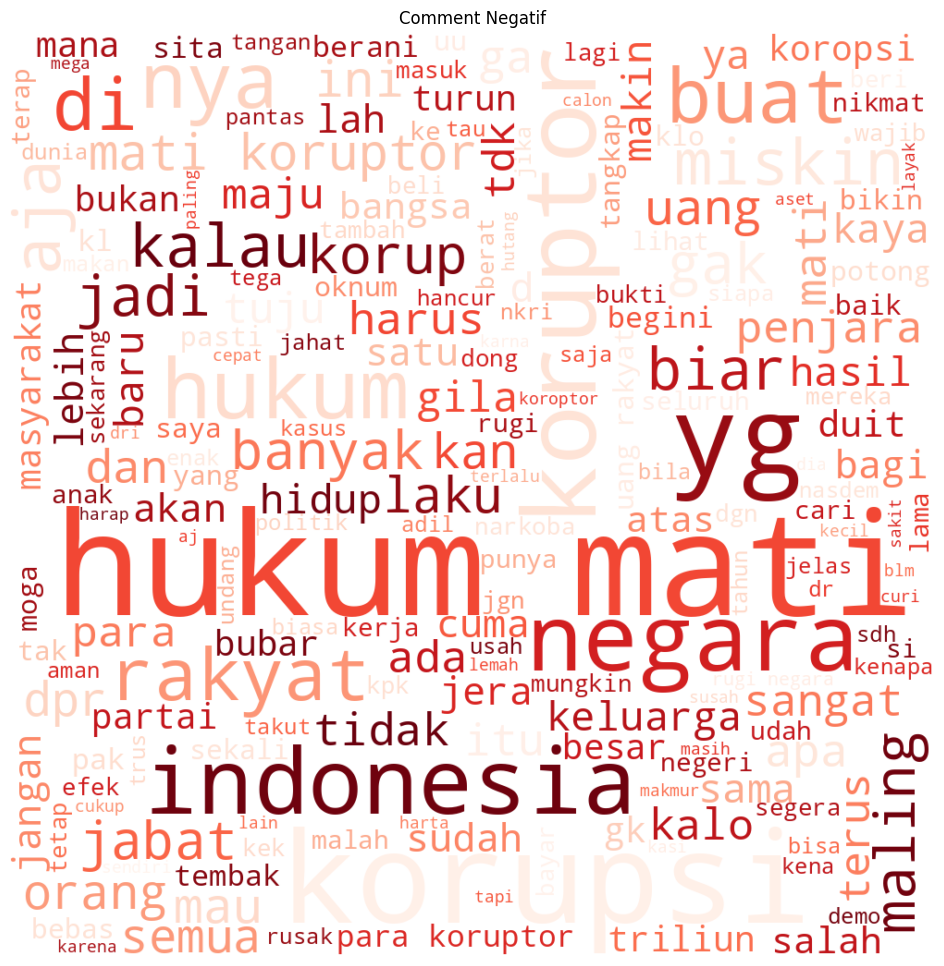

In [15]:
all_text_s0 = ' '.join(word for word in comment_negatif["comment"])
wordcloud = WordCloud(colormap='Reds', width=1000, height=1000, mode='RGBA', background_color='white').generate(all_text_s0)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Comment Negatif")
plt.margins(x=0, y=0)
plt.show()

In [16]:
comment_positif = result[result["label"] == 0]
comment_positif["comment"] = comment_positif["comment"].fillna("Tidak ada komentar")

<ipython-input-16-68b6a7f8da87>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_positif["comment"] = comment_positif["comment"].fillna("Tidak ada komentar")


In [17]:
comment_positif.head()

,comment,label
4,hadir tubuh tubuh besar,0
11,kasi kurang untung karena buat koruptor,0
16,ga bayangin bagi2nya pihak yg kait ga mungkin ...,0
23,lama ada korupsi usaha bebas pajak,0
33,tingkat korupsi klo perlu buka universitas jur...,0


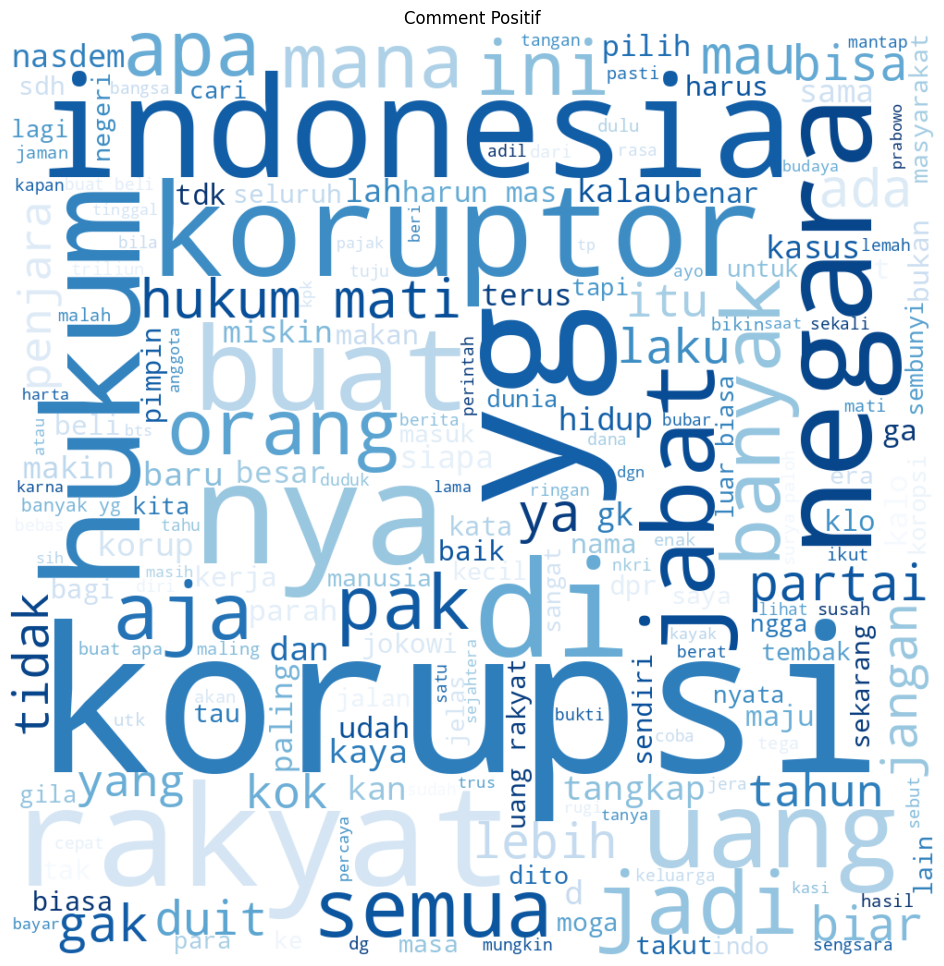

In [18]:
all_text_s1 = ' '.join(word for word in comment_positif["comment"])
wordcloud = WordCloud(colormap='Blues', width=1000, height=1000, mode="RGBA", background_color='white').generate(all_text_s1)
plt.figure(figsize=(24, 12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Comment Positif")
plt.margins(x=0, y=0)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

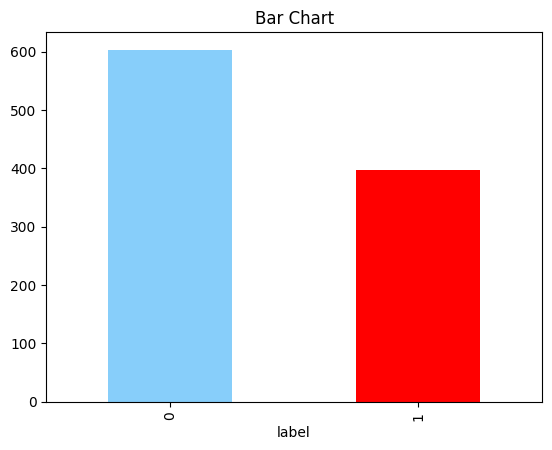

In [19]:
sentimen_data = pd.value_counts(result["label"], sort=True)
sentimen_data.plot(kind='bar', color=['lightskyblue', 'red'])
plt.title("Bar Chart")
plt.show

In [20]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['comment']
        self.labels = dataframe['label']
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )

        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]

        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'attention_mask': torch.tensor(attention_mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'labels': torch.tensor(self.labels[index], dtype=torch.long)
        }

In [21]:
tokenizer = BertTokenizer.from_pretrained("indobenchmark/indobert-base-p1")
model = BertForSequenceClassification.from_pretrained("indobenchmark/indobert-base-p1", num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [22]:
MAX_LEN = 128
BATCH_SIZE = 16

dataset = CustomDataset(df, tokenizer, MAX_LEN)
train_size = 0.8
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [int(train_size*len(dataset)), len(dataset) - int(train_size*len(dataset))])

train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)

In [23]:
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

progress_bar = tqdm(range(num_training_steps))

model.train()
for epoch in range(num_epochs):
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)

  0%|          | 0/150 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
model.eval()
for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

In [26]:
from sklearn.metrics import confusion_matrix, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
model.eval()

all_preds = []
all_labels = []

for batch in val_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)

    all_preds.extend(predictions.cpu().numpy())
    all_labels.extend(batch['labels'].cpu().numpy())

In [29]:
cm = confusion_matrix(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds, average='weighted')
report = classification_report(all_labels, all_preds)

print("Confusion Matrix:")
print(cm)
print("\nF1 Score:")
print(f1)
print("\nClassification Report:")
print(report)

Confusion Matrix:
[[108  17]
 [ 23  52]]

F1 Score:
0.7981770833333335

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       125
           1       0.75      0.69      0.72        75

    accuracy                           0.80       200
   macro avg       0.79      0.78      0.78       200
weighted avg       0.80      0.80      0.80       200



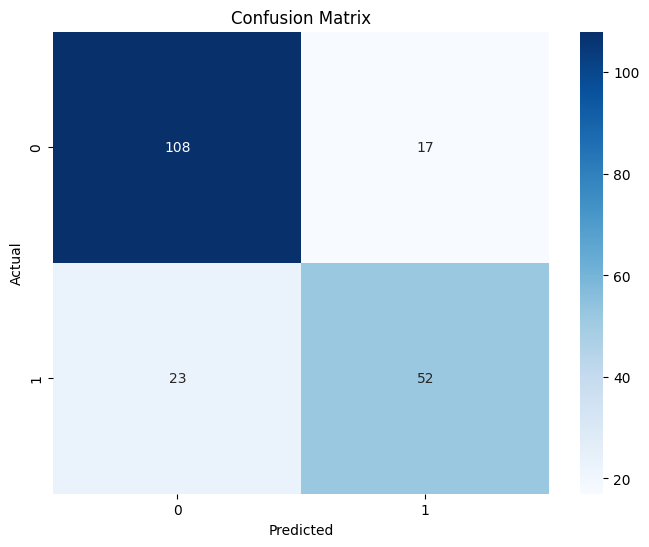

In [30]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()